## Esercizio Classificazione NLP4 - Financial

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/fina.png' width=800>


In [255]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/financial.csv

In [256]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

path = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/financial.csv'

df = pd.read_csv(path)

df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [257]:
neutralDrop = df[df["Sentiment"] == "neutral"].index
df = df.drop(neutralDrop).reset_index(drop=True)
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,$SPY wouldn't be surprised to see a green close,positive
4,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
...,...,...
2707,Operating profit fell to EUR 38.1 mn from EUR ...,negative
2708,HSBC Says Unit to Book $585 Million Charge on ...,negative
2709,Daily Mail parent company in talks with potent...,positive
2710,RISING costs have forced packaging producer Hu...,negative


In [258]:
## STEP1 DEFINIRE ED APPLICARE LA REGEX
import re

patterns = {
    r'\s+': ' ',             # Sostituisce tutti i multipli spazi con uno spazio
    r'\d+': '',              # Rimuove numeri
    r'[^\w\s]': '',          # Rimuove punteggiatura e simboli
    r'\b\w{1,2}\b': '',      # Rimuove tutte le parole con meno di 2 caratteri
    r'(http|www)[^\s]+': '', # Rimuove gli URL
    r'\s+': ' '              # Sostituisce gli spazi multipli con uno spazio (ripetuto, ma necessario per normalizzare)
}


words_to_remove = ['gargamella', 'doggy', 'word3']  # Lista di parole da rimuovere

# Crea un pattern per le parole specifiche da rimuovere
word_pattern = r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b'
patterns[word_pattern] = ''  # Aggiungi il pattern per le parole specifiche

# Funzione per pulire la colonna del DataFrame
def clean_column(df, column, patterns):
    # Assicurati che i valori non stringa vengano trattati come stringhe
    df[column] = df[column].fillna("").astype(str)  # Converti NaN in "" e tutto in stringhe
    
    # Per ogni pattern nel dizionario
    for pattern, replacement in patterns.items():
        # Usa regex=True per assicurarsi che pandas utilizzi regex
        df[column] = df[column].str.replace(pattern, replacement, regex=True)
    
    # Dopo aver fatto tutte le sostituzioni, converte tutto il testo in minuscolo
    df[column] = df[column].str.lower()
    return df

# Assumiamo che tu abbia un DataFrame 'df' e una colonna chiamata 'Text'

# Applica la funzione di pulizia alla colonna 'Text'
df = clean_column(df, 'Sentence', patterns)

In [259]:
print(df['Sentence'])

0       the geosolutions technology will leverage bene...
1                    esi  lows down      real possibility
2       for the last quarter    componenta  net sales ...
3                spy wouldnt  surprised  see  green close
4       shells  billion  deal meets shareholder skepti...
                              ...                        
2707           operating profit fell  eur   from eur     
2708     hsbc says unit  book  million charge  settlement
2709    daily mail parent company  talks with potentia...
2710    rising costs have forced packaging producer hu...
2711    helsinki afx  kci konecranes said  has won  or...
Name: Sentence, Length: 2712, dtype: object


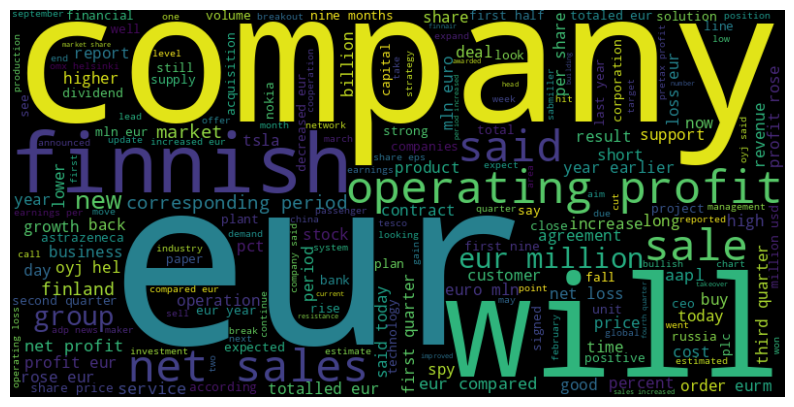

In [260]:
## STEP 2 : EDA con WORDCLOUD
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unisci tutto il testo per creare una sola stringa
all_text = " ".join(df['Sentence'])

# Crea la WordCloud
wordcloud = WordCloud(width=800, height=400).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [261]:
##STEP 3: Definizre X e y (features testuali e Target)
X = df['Sentence']
y = df['Sentiment'] 

In [262]:
##STEP 4: Vettorizzazione - Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(X)

In [263]:
##STEP 5: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [264]:
##STEP 6: Split Training and Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [265]:
##STEP 7: Modellazione
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7845303867403315


In [266]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, patterns):
        self.patterns = patterns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=['text'])
        df = clean_column(df, 'text', self.patterns)

        # Rimuovi parole troppo corte
        df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))  
        
        # Se la frase è troppo corta o vuota, restituisci un valore di fallback
        df['text'] = df['text'].apply(lambda x: x if len(x.split()) > 0 else "fallback text")
        
        return df['text'].values

In [267]:
# Step 8: Pipeline Finale (nuovo train test split su dati raw tetuali)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Creazione della pipeline
text_cleaner = TextCleaner(patterns)
bow = CountVectorizer(max_features=15000, stop_words=None)
tfidf = TfidfTransformer()
clf = MultinomialNB(alpha=0.1)

model_pipe = Pipeline([
    # ('text cleaner', text_cleaner),  ## Pulizia con regex
    ('bow', bow),                    ## Bag of Words
    ('tfidf', tfidf),                ## TF-IDF
    ('classifier', clf),             ## Classificatore Naive Bayes
])

X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.2, random_state=42)

model_pipe.fit(X_train, y_train)
y_pred = model_pipe.predict(X_test)

accuracy = model_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7937384898710865


In [272]:
single_text = ["The NaviT###ech system will enh56335ance NavCom’s GPS sol653356utions by integrati785ng location-based search t##echnology with only $150"]  # Esempio di input
single_prediction = model_pipe.predict(single_text)
print(f"Predicted sentiment: {single_prediction}")

Predicted sentiment: ['positive']


# Lei dopo aver letto la verifica


<img src="https://doctorvet.it/wp-content/uploads/2020/01/gatto-che-si-gonfia-impaurito.jpg" width="1200">
